--- INICIANDO EJECUCIÓN DEL PROYECTO ---
>> Datos cargados correctamente.

--- MUESTRA DE DATOS ORIGINALES (RAW) ---


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



--- AUDITORÍA DE CALIDAD DE DATOS ---


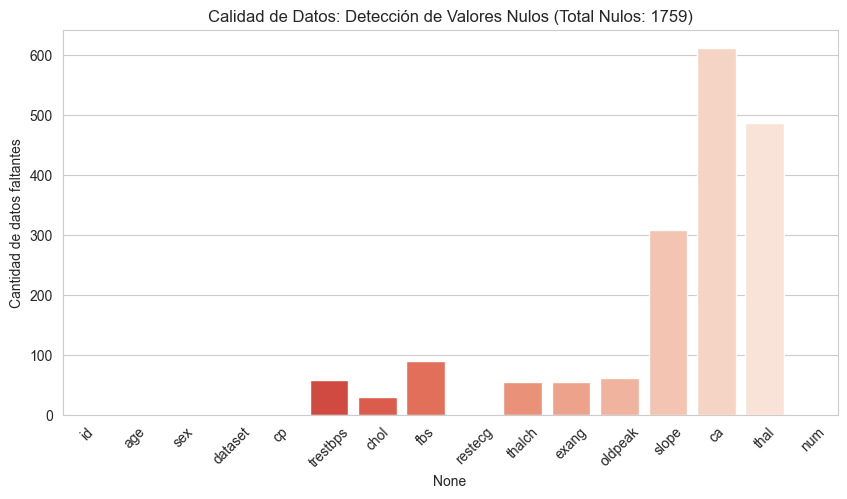

Total inicial de pacientes: 920
Pacientes con historial clínico COMPLETO: 299
Pacientes descartados por datos incompletos: 621
Filas duplicadas detectadas: 0

NOTA TÉCNICA: Se conservan los pacientes (principalmente Cleveland) con historial completo.
Las bases de Hungría/Suiza carecen de variables críticas ('ca', 'thal').
Se prioriza la CALIDAD del dato sobre la CANTIDAD.

--- TRANSFORMACIÓN Y CODIFICACIÓN (ETL) ---
Generando diccionario de codificación:


,Columna,Valor Original,Código Numérico
0,sex,Female,0
1,sex,Male,1
2,dataset,Cleveland,0
3,dataset,Hungary,1
4,dataset,VA Long Beach,2
5,cp,asymptomatic,0
6,cp,atypical angina,1
7,cp,non-anginal,2
8,cp,typical angina,3
9,fbs,False,0


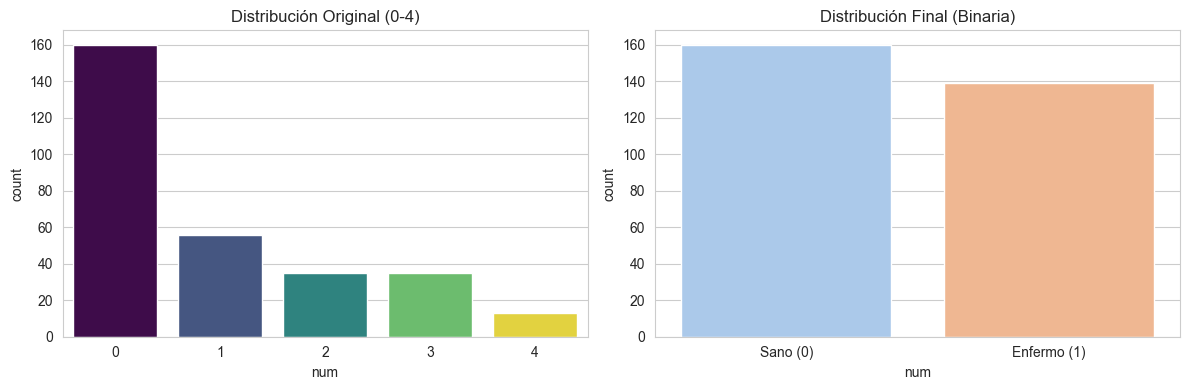

 -> Variable objetivo 'num' binarizada.

[MODELO] Precisión (Accuracy) en Test Set: 0.85

[XAI - TÉCNICA 1] Calculando Permutation Importance...


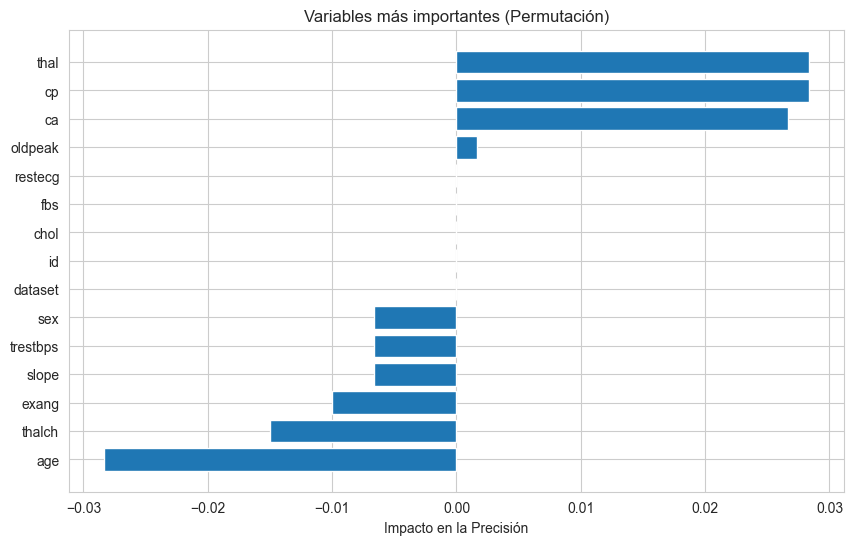


[XAI - TÉCNICA 2] Calculando valores SHAP...


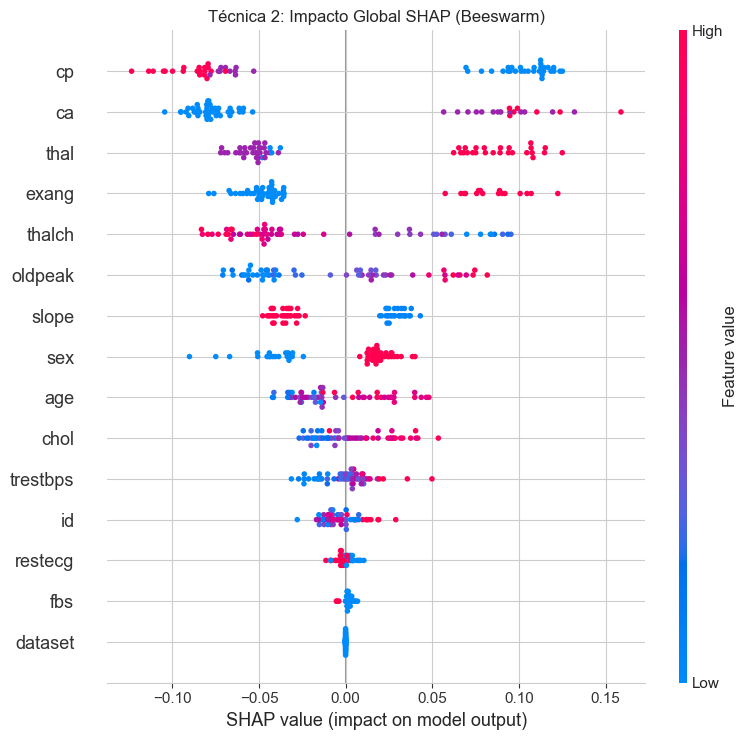


[XAI - CASO INDIVIDUAL] Paciente #0 del Test Set...
 -> Predicción: ENFERMEDAD


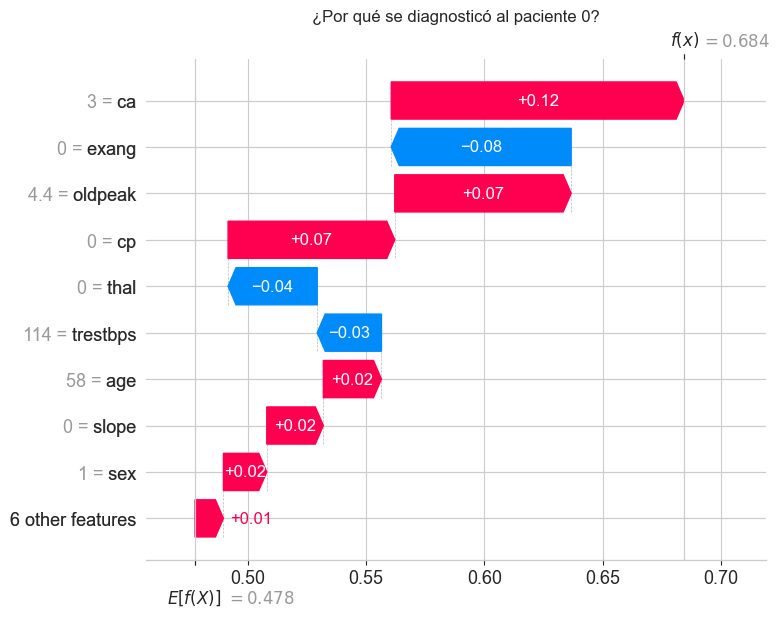


[ÉTICA] Auditoría de Sesgo Algorítmico (Hombres vs Mujeres)...

1. REPRESENTATIVIDAD EN TEST SET:
 - Mujeres: 21 (35.0%)
 - Hombres: 39 (65.0%)


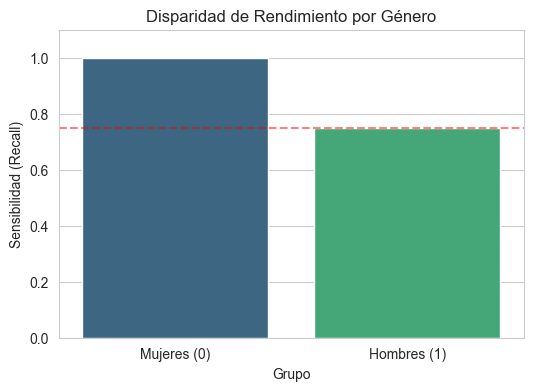

 -> Sensibilidad Mujeres: 1.00
 -> Sensibilidad Hombres: 0.75
ALERTA: Sesgo significativo detectado.

2. VERIFICACIÓN DE ENTRENAMIENTO (¿Qué estudió el modelo?):
 - Mujeres vistas: 75 (31.4%)
 - Hombres vistos: 164 (68.6%)


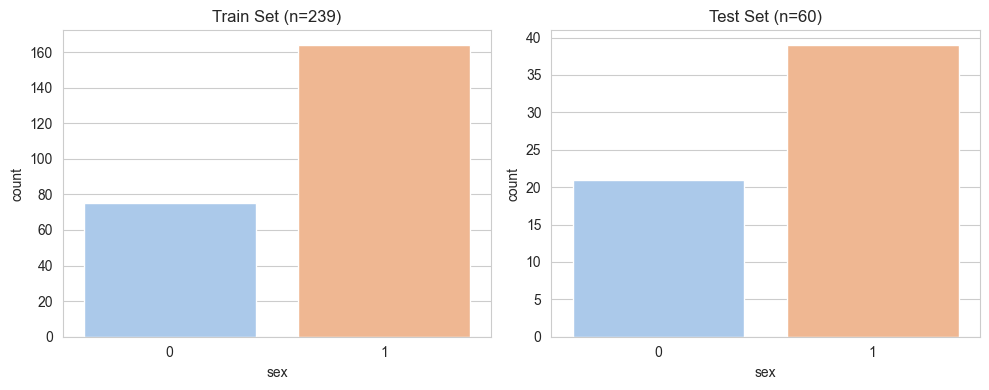


3. AUDITORÍA DE REALIDAD (¿Quiénes estaban realmente enfermos?):
 - % de Mujeres que realmente tenían la enfermedad: 26.0%
 - % de Hombres que realmente tenían la enfermedad: 56.2%


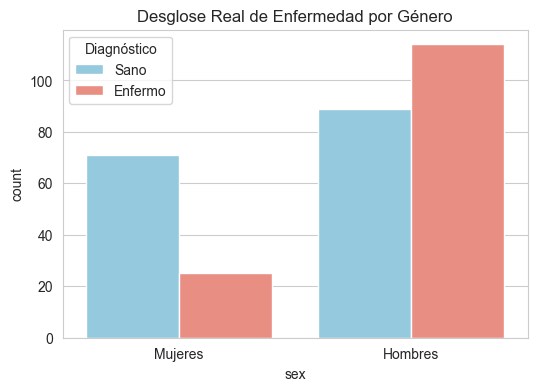


--- FIN DEL PROCESO ---


In [4]:
# =============================================================================
# PROYECTO FINAL: XAI, ÉTICA Y CALIDAD EN ML
# Dataset: Heart Disease UCI (Cleveland & others)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Configuración visual para gráficos profesionales
sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

print("--- INICIANDO EJECUCIÓN DEL PROYECTO ---")

# =============================================================================
# 1. CARGA DE DATOS Y ANÁLISIS DE CALIDAD VISUAL
# =============================================================================
# URL del dataset.
url = "heart_disease_uci.csv" 
# Si no tienes el archivo local, descomenta la siguiente línea para descargar de internet:
# url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/heart.csv"

try:
    df = pd.read_csv(url)
    print(">> Datos cargados correctamente.")
except:
    print(">> Error cargando archivo. Asegúrate de que el .csv esté correcto o usa la URL web.")
    raise SystemExit("Deteniendo ejecución.")

# --- A. INSPECCIÓN VISUAL INICIAL ---
print("\n--- MUESTRA DE DATOS ORIGINALES (RAW) ---")
try:
    display(df.head())
except:
    print(df.head())

# --- B. AUDITORÍA DE CALIDAD DE DATOS ---
print("\n--- AUDITORÍA DE CALIDAD DE DATOS ---")
nulos = df.isnull().sum()
duplicados = df.duplicated().sum()

# [VISUALIZACIÓN] Mapa de Nulos
plt.figure(figsize=(10, 5))
sns.barplot(x=nulos.index, y=nulos.values, palette='Reds_r', hue=nulos.index, legend=False)
plt.xticks(rotation=45)
plt.title(f"Calidad de Datos: Detección de Valores Nulos (Total Nulos: {nulos.sum()})")
plt.ylabel("Cantidad de datos faltantes")
plt.show()

# Limpieza rigurosa
print(f"Total inicial de pacientes: {len(df)}")
df_clean = df.dropna()
print(f"Pacientes con historial clínico COMPLETO: {len(df_clean)}")
print(f"Pacientes descartados por datos incompletos: {len(df) - len(df_clean)}")
print(f"Filas duplicadas detectadas: {duplicados}")

print("\nNOTA TÉCNICA: Se conservan los pacientes (principalmente Cleveland) con historial completo.")
print("Las bases de Hungría/Suiza carecen de variables críticas ('ca', 'thal').")
print("Se prioriza la CALIDAD del dato sobre la CANTIDAD.")

# =============================================================================
# 2. PRE-PROCESAMIENTO Y CODIFICACIÓN
# =============================================================================
print("\n--- TRANSFORMACIÓN Y CODIFICACIÓN (ETL) ---")

cat_columns = df_clean.select_dtypes(include=['object']).columns
df_encoded = df_clean.copy()

print("Generando diccionario de codificación:")
encoding_map = []

for col in cat_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_clean[col].astype(str))
    
    # Guardamos mapeo
    classes = le.classes_
    for i, cls in enumerate(classes):
        encoding_map.append({'Columna': col, 'Valor Original': cls, 'Código Numérico': i})

# Mostrar diccionario
try:
    display(pd.DataFrame(encoding_map))
except:
    print(pd.DataFrame(encoding_map))

# Normalización de nombres
df_encoded.columns = [c.lower() for c in df_encoded.columns]

# --- C. TRANSFORMACIÓN DEL TARGET (Binarización) ---
target_col = 'num' if 'num' in df_encoded.columns else 'target'
if target_col not in df_encoded.columns: target_col = df_encoded.columns[-1]

# Visualización 3: Transformación de la variable objetivo
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=target_col, data=df_encoded, palette='viridis', hue=target_col, legend=False)
plt.title("Distribución Original (0-4)")

# Transformación: 0=Sano, >0=Enfermo
df_encoded[target_col] = df_encoded[target_col].apply(lambda x: 1 if x > 0 else 0)

plt.subplot(1, 2, 2)
sns.countplot(x=target_col, data=df_encoded, palette='pastel', hue=target_col, legend=False)
plt.title("Distribución Final (Binaria)")
plt.xticks([0, 1], ['Sano (0)', 'Enfermo (1)'])
plt.tight_layout()
plt.show()

print(f" -> Variable objetivo '{target_col}' binarizada.")
df_clean = df_encoded

# =============================================================================
# 3. ENTRENAMIENTO DEL MODELO
# =============================================================================
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo: Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

acc = accuracy_score(y_test, model.predict(X_test))
print(f"\n[MODELO] Precisión (Accuracy) en Test Set: {acc:.2f}")

# =============================================================================
# 4. TÉCNICA XAI 1: PERMUTATION IMPORTANCE
# =============================================================================
print("\n[XAI - TÉCNICA 1] Calculando Permutation Importance...")
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Impacto en la Precisión")
plt.title("Variables más importantes (Permutación)")
plt.show()

# =============================================================================
# 5. TÉCNICA XAI 2: SHAP (Global y Local)
# =============================================================================
print("\n[XAI - TÉCNICA 2] Calculando valores SHAP...")
explainer = shap.TreeExplainer(model)
shap_values_raw = explainer.shap_values(X_test)

# Manejo de dimensiones (Fix para versiones distintas de SHAP)
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]
elif len(np.array(shap_values_raw).shape) == 3:
    shap_values = shap_values_raw[:, :, 1]
else:
    shap_values = shap_values_raw

# Global
plt.figure()
plt.title("Técnica 2: Impacto Global SHAP (Beeswarm)")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

# Local (Caso Individual)
print("\n[XAI - CASO INDIVIDUAL] Paciente #0 del Test Set...")
explanation = explainer(X_test)
if len(explanation.shape) == 3:
    explanation_patient = explanation[0, :, 1]
else:
    explanation_patient = explanation[0]

print(f" -> Predicción: {'ENFERMEDAD' if model.predict(X_test.iloc[[0]])[0]==1 else 'SANO'}")
plt.figure()
shap.plots.waterfall(explanation_patient, show=False)
plt.title("¿Por qué se diagnosticó al paciente 0?", fontsize=12)
plt.show()

# =============================================================================
# 6. AUDITORÍA ÉTICA Y DE SESGOS
# =============================================================================
print("\n[ÉTICA] Auditoría de Sesgo Algorítmico (Hombres vs Mujeres)...")

if 'sex' in X_test.columns:
    mask_female = X_test['sex'] == 0
    mask_male = X_test['sex'] == 1
    
    # --- A. Verificación de Representatividad (Test Set) ---
    count_female = mask_female.sum()
    count_male = mask_male.sum()
    
    print("\n1. REPRESENTATIVIDAD EN TEST SET:")
    print(f" - Mujeres: {count_female} ({(count_female/len(X_test))*100:.1f}%)")
    print(f" - Hombres: {count_male} ({(count_male/len(X_test))*100:.1f}%)")
    
    if count_female < 20:
        print("   (!) ADVERTENCIA: Muestra de mujeres pequeña. Resultados estadísticos frágiles.")

    # --- B. Rendimiento (Sensibilidad) ---
    rec_female = recall_score(y_test[mask_female], model.predict(X_test[mask_female]), zero_division=0)
    rec_male = recall_score(y_test[mask_male], model.predict(X_test[mask_male]), zero_division=0)
    
    bias_data = pd.DataFrame({
        'Grupo': ['Mujeres (0)', 'Hombres (1)'],
        'Sensibilidad (Recall)': [rec_female, rec_male]
    })
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Grupo', y='Sensibilidad (Recall)', data=bias_data, palette='viridis', hue="Grupo", legend=False)
    plt.title("Disparidad de Rendimiento por Género")
    plt.ylim(0, 1.1)
    plt.axhline(y=rec_male, color='r', linestyle='--', alpha=0.5)
    plt.show()
    
    print(f" -> Sensibilidad Mujeres: {rec_female:.2f}")
    print(f" -> Sensibilidad Hombres: {rec_male:.2f}")
    
    if abs(rec_female - rec_male) > 0.1:
        print("ALERTA: Sesgo significativo detectado.")
    
    # --- C. Verificación de Entrenamiento (Train Set) ---
    print("\n2. VERIFICACIÓN DE ENTRENAMIENTO (¿Qué estudió el modelo?):")
    c_train_f = X_train[X_train['sex'] == 0].shape[0]
    c_train_m = X_train[X_train['sex'] == 1].shape[0]
    print(f" - Mujeres vistas: {c_train_f} ({(c_train_f/len(X_train))*100:.1f}%)")
    print(f" - Hombres vistos: {c_train_m} ({(c_train_m/len(X_train))*100:.1f}%)")
    
    # Comparativa visual Train vs Test
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.countplot(x='sex', data=X_train, palette='pastel', hue='sex', legend=False, ax=axes[0])
    axes[0].set_title(f"Train Set (n={len(X_train)})")
    sns.countplot(x='sex', data=X_test, palette='pastel', hue='sex', legend=False, ax=axes[1])
    axes[1].set_title(f"Test Set (n={len(X_test)})")
    plt.tight_layout()
    plt.show()

    # --- D. Auditoría de Enfermedad Real (Ground Truth) ---
    print("\n3. AUDITORÍA DE REALIDAD (¿Quiénes estaban realmente enfermos?):")
    
    # Unimos todo para ver la estadística global
    full_data = pd.concat([X, y], axis=1) # Usamos el dataset limpio completo
    
    sick_rate_f = full_data[(full_data['sex']==0) & (full_data[target_col]==1)].shape[0] / full_data[full_data['sex']==0].shape[0]
    sick_rate_m = full_data[(full_data['sex']==1) & (full_data[target_col]==1)].shape[0] / full_data[full_data['sex']==1].shape[0]
    
    print(f" - % de Mujeres que realmente tenían la enfermedad: {sick_rate_f*100:.1f}%")
    print(f" - % de Hombres que realmente tenían la enfermedad: {sick_rate_m*100:.1f}%")
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sex', hue=target_col, data=full_data, palette={0: 'skyblue', 1: 'salmon'})
    plt.title("Desglose Real de Enfermedad por Género")
    plt.xticks([0, 1], ['Mujeres', 'Hombres'])
    plt.legend(title='Diagnóstico', labels=['Sano', 'Enfermo'])
    plt.show()

else:
    print("No se encontró columna 'sex'.")

print("\n--- FIN DEL PROCESO ---")